# Problem Description

This notebook will guide you through implementation of **multivariate linear regression** to solve the **polynomial regression** problem:

$$
h_{w}(x) = w_0 + w_1 x + w_2 x^2 +  w_3 x^3 + w_4 x^4
= \boldsymbol{w}^T \mathbf{x}
$$

$$
\boldsymbol{w} = \begin{bmatrix}w_0 \\ w_1 \\ w_2 \\ w_3 \\ w_4\end{bmatrix}, 
\qquad
\mathbf{x} = \begin{bmatrix}1 \\ x \\ x^2 \\ x^3 \\ x^4\end{bmatrix}
$$

Below, you will follow steps to 

1. Implement the cost function for multivarate linear regression
1. Compare vectorized code with for-loops
1. Implement the normal equations method to solve a multivariate linear regression problem
1. Implement gradient descent for multivariate linear regression
1. Experiment with feature normalization to improve the convergence of gradient descent


## Imports
Run this code.

In [1]:
%matplotlib inline
import time
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

## Helper functions
Run this code to set up the helper functions. The function ``feature_expansion`` accepts an vector of $n$ scalar x values and returns an $n \times 5$ data matrix by applying the feature expansion $x \mapsto [1, x, x^2, x^3, x^4]$ to each scalar $x$ value.

In [2]:
def feature_expansion(x, deg):
    if x.ndim > 1:
        raise ValueError('x should be a 1-dimensional array')
    m = x.shape
    x_powers = [x**k for k in range(0,deg+1)]
    X = np.stack( x_powers, axis=1 )

    return X

def plot_model(X_test, w):
    '''
    Note: uses globals x, y, x_test, which are assigned below
    when the dataset is created. Don't overwrite these variables.
    '''
    y_test = np.dot(X_test, w)
    plt.scatter(x, y)
    plt.plot(x_test, y_test)
    plt.legend(['Test', 'Train'])

## (2 points) List comprehensions

Read about Python list comprehensions. Explain what is happening in the following line of code

```python
x_powers = [x**k for k in range(0,deg+1)]
```

Python list comprehennsion template goes like this:
```python
my_list = [expression for i in iterable if condition].
```
Since we do not have any conditions we can ignore if statemenet.
In the rest of that line my_list will be created and expanded as the for loop goes on.
Looking at our own example, x_powers will be a list of vectors of powers of x from 0 to 4.
In the most simplest form this code can be implemented as following: 

```python
x_powers = []
for k in range (0, deg+1):
    x_powers.append(x**k)
```

x**k  represents x^k or power(x, k)  - kth power of x


## Create a data set for polynomial regression

Read and run the code below. This generates data from a fourth-degree polynomial and then uses feature expansion to set up the problem of learning the polynomial as multivariate linear regression

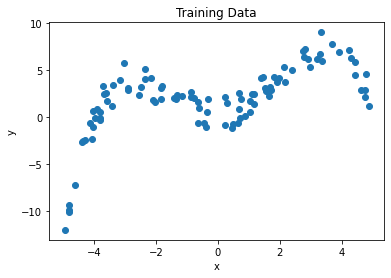

In [3]:
# Set random seed
np.random.seed(0)

# Create random set of m training x values between -5 and 5
m = 100
x = np.random.rand(m)*10 - 5   

# Create evenly spaced test x values (for plotting)
x_test  = np.linspace(-5, 5, 100)
m_test  = len(x_test)

# Feature expansion for training and test x values
deg = 4
X      = feature_expansion(x, deg)
X_test = feature_expansion(x_test, deg)

n = deg + 1   # total number of features including the '1' feature

# Define parameters (w) and generate y values
w = 0.1*np.array([1, 1, 10, 0.5, -0.5])
y = np.dot(X, w) + np.random.randn(m)   # polynomial plus noise

# Plot the training data
plt.scatter(x, y)
plt.title('Training Data')
plt.xlabel('x')
plt.ylabel('y')
plt.show()


In [4]:
#look at the feature expansion for a single training example
print(x[0]) #original data 
print(X[0]) #data with feature expansion

0.48813503927324753
[1.         0.48813504 0.23827582 0.11631078 0.05677536]


## Implement the cost function
Follow the instructions to implement the following cost function for multivariate linear regression:

$$J(w) = \frac{1}{2}\sum_{i=1}^n(h_{w}(x^{(i)})-y^{(i)})^2$$

### (3 points)  Cost function with loops 
First, implement the cost function using a for-loops: `cost_function_loops`.

In [5]:
def cost_function_loops(X, y, w):  
    '''
    Compute the cost function for a particular data set and 
    hypothesis (parameter vector)
    
    
    Inputs: 
        X       m x n data matrix
        y       training output (length m vector)
        w   parameters (length n vector)
    Output:
        cost    the value of the cost function (scalar)
    '''
    
    ''' cost function implementation with one for loop
    cost = 0    
    for i in range(len(X)):
        cost = cost + (y[i] - np.matmul(X[[i], :], w))**2
    
    cost = cost/2
    '''
    
    '''Or cost function can be implemented with two for loops, (both give the same results)'''
    cost  = 0
    for i in range(len(X)):
        y_hat_i = 0
        for j in range(len(w)):
            y_hat_i = y_hat_i + X[i, j] * w[j]
        
        cost = cost + (y[i] - y_hat_i)**2

    cost = cost/2
    
    return cost

### (3 points)  Vectorized cost function 
Now, implment the same cost function but now WITHOUT any for-loops. You should be using NumPy. This is a "vectorized" version of the cost function: `cost_function_vec`

In [6]:
def cost_function_vec(X, y, w):  
    '''
    No for-loops allowed! 
    
    Compute the cost function for a particular data set and 
    hypothesis (parameter vector)
    
    Inputs: 
        X       m x n data matrix
        y       training output (length m vector)
        w   parameters (length n vector)
    Output:
        cost    the value of the cost function (scalar)
    '''
    
    cost = 1/2 * np.matmul(np.transpose(y-np.matmul(X, w)), y - np.matmul(X, w))
    
    return cost

## Test the cost function
Run this to test your cost function.

In [7]:
np.random.seed(1)

w_random = np.random.rand(n)
w_zeros  = np.zeros(n)
w_ones   = np.ones(n)

print("cost_function_loops")
print("=="*10)
print( "Cost (random): %.2f" % cost_function_loops(X, y, w_random))  # prints 54523.64
print( "Cost (zeros): %.2f" % cost_function_loops(X, y, w_zeros))   # prints 845.65
print( "Cost (ones): %.2f" % cost_function_loops(X, y, w_ones))    # prints 2524681.08
print()
print("cost_function_vec")
print("=="*10)
print( "Cost (random): %.2f" % cost_function_vec(X, y, w_random))  # prints 54523.64
print( "Cost (zeros): %.2f" % cost_function_vec(X, y, w_zeros))   # prints 845.65
print( "Cost (ones): %.2f" % cost_function_vec(X, y, w_ones))    # prints 2524681.08
print()
#Note: The for-loop and vectorized cost function implementations should return the EXACT 
# same results. 

cost_function_loops
Cost (random): 54523.64
Cost (zeros): 845.65
Cost (ones): 2524681.08

cost_function_vec
Cost (random): 54523.64
Cost (zeros): 845.65
Cost (ones): 2524681.08



## (2 points)  Time cost functions 

- Run `cost_function_loops` and `cost_function_vec` each 100 times for `w_random` and the `X` and `y` given above
- Print out the mean and standard deviation across all runs for each function 
- Report which function is faster.  

In [8]:
np.random.seed(1)
w_random = np.random.rand(n)
##################

timeCostFunctionLoops = []
timeCostFunctionVec = []

# run cost function loop 100 times
for i in range(100):
    tic = time.time()
    cost_function_loops(X, y, w_random)
    toc = time.time()
    timeCostFunctionLoops.append(toc - tic)

# run cost function vectorized 100 times
for i in range(100):
    tic = time.time()
    cost_function_vec(X, y, w_random)
    toc = time.time()
    timeCostFunctionVec.append(toc - tic)

timeCostFunctionLoops_mean = np.mean(timeCostFunctionLoops)
timeCostFunctionVec_mean = np.mean(timeCostFunctionVec)
timeCostFunctionLoops_std = np.std(timeCostFunctionLoops)
timeCostFunctionVec_std = np.std(timeCostFunctionVec)

print('in seconds ... ')
print(f'mean time for cost_function_loops: {timeCostFunctionLoops_mean:0.6f}')
print(f'mean time for cost_function_vec: {timeCostFunctionVec_mean:0.6f} ')

print(f'standart deviation of time for cost_function_loops: {timeCostFunctionLoops_std:0.6f}')
print(f'standart deviation of time for cost_function_vec: {timeCostFunctionVec_std:0.6f}')



in seconds ... 
mean time for cost_function_loops: 0.000657
mean time for cost_function_vec: 0.000000 
standart deviation of time for cost_function_loops: 0.002532
standart deviation of time for cost_function_vec: 0.000000


Vectorized implementation is around 100 to 1000 times faster than loops

### For the rest of this notebook, we will use the vectorized implementation of the cost function 
Run the code below. 

In [9]:
cost_function = cost_function_vec

In [10]:
#make sure it works 
cost_function(X, y, w_random)

54523.64276966483

## (7 points) Implement first training algorithm: normal equations
Implement a *vectorized* version of the normal equations! If you use for-loops you will not get full credit. 

In [11]:
def normal_equations(X, y):
    '''
    Train a linear regression model using the normal equations

    Inputs: 
        X       m x n data matrix
        y       training output (length m vector)
    Output:
        w       parameters (length n vector)

    '''
    m, n = X.shape
    # closed form solution: set cost function gradient to zero
    w = np.matmul(np.matmul(np.linalg.inv(np.matmul(np.transpose(X), X)), np.transpose(X)), y)

    return w

## Use normal equations to fit the model
Run this code to test your implementation of the normal equations. If it runs properly you will see a curve that fits the data well. Note the value of the cost function for ``w_normal_equations``.

Cost function: 48.54


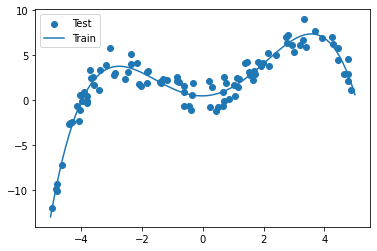

In [12]:
w_normal_equations = normal_equations(X, y)
plot_model(X_test, w_normal_equations)
print ("Cost function: %.2f" % cost_function(X, y, w_normal_equations))

## (7 points) Implement second training algorithm: (vectorized) gradient descent

Implement gradient descent for multivariate linear regression. Make sure your solution is vectorized. If you use for-loops to compute the gradient you will not receive full credit. 

In [13]:
def gradient_descent( X, y, alpha, iters, w=None ):
    '''
    Train a linear regression model by gradient descent

    Inputs: 
        X       m x n data matrix
        y       training output (length m vector)
        alpha   step size
        iters   number of iterations
        w   initial parameter values (length n vector; optional)
    
    Output:
        w      learned parameters (length n vector)
        J_history  trace of cost function value in each iteration

    '''

    m,n = X.shape
    
    if w is None:
        w = np.zeros(n)

    tol = 1e-10
    J_history = np.zeros(iters)
    i = 0
    grad = -1* np.matmul(np.transpose(X), (y - np.matmul(X, w)))

    while np.linalg.norm(grad, ord=2) > tol and i<iters: 
        w = w - alpha * grad
        grad = -1* np.matmul(np.transpose(X), (y - np.matmul(X, w)))

        # Record cost function
        J_history[i] = cost_function(X, y, w)
        i +=1 

    print('L2 norm of gradient: ', np.linalg.norm(grad, ord=2))
    return w, J_history

## (6 points) Use gradient descent to train the model
* Write code to call your ``gradient_descent`` method to learn parameter
* Plot the model fit (use ``plot_model``)
* Plot the cost function vs. iteration to help assess convergence
* Print the final value of the cost function
* Experiment with different step sizes and numbers of iterations until you can find a good hypothesis. Try to match the cost function value from ``normal_equations`` to two decimal places. How many iterations does this take?

L2 norm of gradient:  0.4491412701041204
Cost function: 48.54


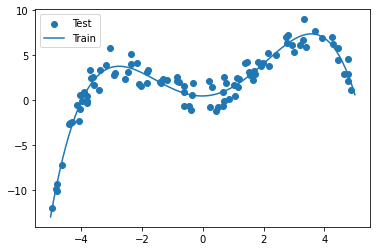

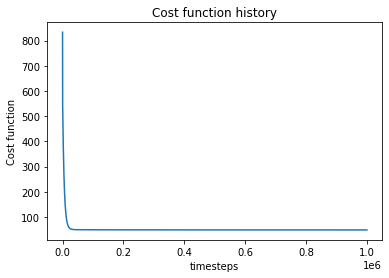

In [14]:
# call gradient descent to solve
w_gradient_descent, J_history = gradient_descent(X, y, 1e-7, iters = 1000000)

# plot model 
plot_model(X_test, w_gradient_descent)

# plot cost function in log scale
plt.figure()
plt.plot(J_history)
plt.xlabel('timesteps')
plt.ylabel('Cost function')
plt.title('Cost function history')

print ("Cost function: %.2f" % cost_function(X, y, w_gradient_descent))



Any step size greate than 1e-7 did not work. I ended up getting overflow. So, step size maximum limit is 1e-7. When number of iterations is set to 1e5 the run time is not that long and final cost function is very close to closed form solution (49.14). To match closed form solution to the second decimal, the number iterations should be at least 1e6. This takes around 1 minute to run. 

## (10 points) Gradient descent with feature normalization
You should have observed
that it takes many iterations of gradient descent to match the cost
function value achieved by the normal equations. Now
you will implement feature normalization to improve the convergence
of gradient descent. Use the following formula
for feature normalization:

$$x^{(i)}_j \leftarrow \frac{x^{(i)}_j - \mu_j}{\sigma_j}$$

Here are some guidelines for the implementation:

* The same transformation should be applied to train and test data.

* The values $\mu_j$ and $\sigma_j$ are the mean and standard deviation of
the $j$th column (i.e., feature) in the **training data**. (Hint:
there are numpy functions to compute these.)

* Do not normalize the column of all ones. (Optional question: why?)

* Use broadcasting to do the normalization--don't write for loops

After normalizing both the training data and test data, follow the same steps as above to experiment with gradient descent using the *normalized* training and test data: print the value of the cost function, and create the same plots. Tune the step size and number of iterations again to make gradient descent converge as quickly as possible. How many iterations does it take to match the cost function value from ``normal_equations`` to two decimal places?  


In [15]:
def normalize_features(X_train, X_test):
    '''
    Normalize features of X based on mean and standart deviation.

    Inputs: 
        X_train       m x n train data matrix unnormalized
        X_test        m x n test data matrix unnormalized
    
    Outputs:
        X_train       m x n train data matrix normalized
        X_test        m x n test data matrix normalized
    '''

    m,n = X.shape
    mean_of_features = [np.mean(X_train[:, i]) for i in range(1, n)]
    std_of_features = [np.std(X_train[:, i]) for i in range(1, n)]

    print(mean_of_features)
    print(std_of_features)

    X_train[:, 1:] = (X_train[:, 1:] - mean_of_features)/std_of_features
    X_test[:, 1:] = (X_test[:, 1:] - mean_of_features)/std_of_features

    # print(X_train)
    # print(X_test)

    return X_train, X_test


[-0.27206160487482345, 8.3857990622863, -5.157243677092947, 129.10072347609264]
[2.8830160501529014, 7.666752739136097, 48.11746090815848, 170.87764063837332]
L2 norm of gradient:  0.1447953758679879
Cost function: 48.54


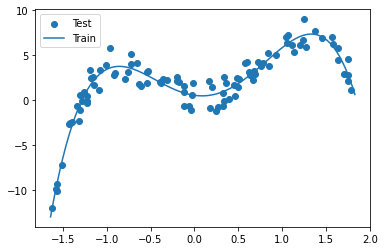

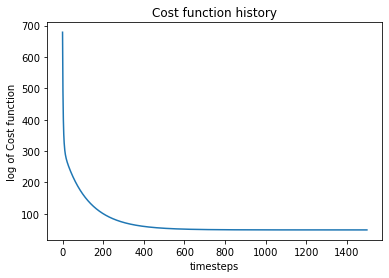

In [16]:
# normalize data 
X_train_norm, X_test_norm = normalize_features(X, X_test)

# call gradient descent to solve on normalized data
w_gradient_descent_nrom, J_history_norm = gradient_descent(X_train_norm, y, 1e-3, iters = 1500)

# plot model fit
plt.figure()
y_test_norm = np.dot(X_test_norm, w_gradient_descent_nrom)
# print(y_test_norm)
# print(X_test_norm[:, 1])

plt.scatter(X_train_norm[:, 1], y)
plt.plot(X_test_norm[:, 1],   y_test_norm)
plt.legend(['Test', 'Train'])

# plot cost function in log scale
J_history = np.log(J_history_norm)
plt.figure()
plt.plot(J_history_norm)
plt.xlabel('timesteps')
plt.ylabel('log of Cost function')
plt.title('Cost function history')

print ("Cost function: %.2f" % cost_function(X_train_norm, y, w_gradient_descent_nrom))


On normalized data, it takes way less time to converge. Step size 1e-2 did not converge.  With step size of 1e-3 it takes 1500 iterations to get the same cost function as closed form solution. 


To answer the question why the "1" feature should not be included in normalization: It is because if we normalize it we will get a different regression equation. The first feature that is multiplied to w0 (zeroth weight) will no longer be one. It will look something like this 

$$
h_{w}(x) = w_0 x^c + w_1 x + w_2 x^2 +  w_3 x^3 + w_4 x^4
= \boldsymbol{w}^T \mathbf{x}
$$

$$
\boldsymbol{w} = \begin{bmatrix}w_0 \\ w_1 \\ w_2 \\ w_3 \\ w_4\end{bmatrix}, 
\qquad
\mathbf{x} = \begin{bmatrix}x^c \\ x \\ x^2 \\ x^3 \\ x^4\end{bmatrix}
$$

Where value of c will depend on mean and standart deviation of expanded matrix X